In [17]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image
from pathlib import Path
import torchvision
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from random import sample

class SpectrogramDataset(Dataset):
    def __init__(self, spectro_folder):
        self.spectrogram_folders = list(spectro_folder.glob('spectrogram_*'))
        self.transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: torch.flatten(x)),
        ])

    def __len__(self):
        return len(self.spectrogram_folders)

    def __getitem__(self, idx):
        folder_path = self.spectrogram_folders[idx]

        # Load the spectrogram image
        img = Image.open(folder_path / 'spectrogram.png') #.convert('L')
        img = self.transform(img)

        # Load the label
        label_path = folder_path / 'label.txt'
        with open(label_path, 'r') as label_file:
            label = int(label_file.read().strip())

        return img, label

# Path to the folder containing your spectrograms
spectro_folder = Path('./spectrograms')

# Create a custom dataset
Data = SpectrogramDataset(spectro_folder)

unique_labels = set()

for _, label in Data:
    unique_labels.add(label)

class_indices = {label: [] for label in unique_labels}

for idx in range(len(Data)):
    _, label = Data[idx]
    class_indices[label].append(idx)

selected_indices = []
for label, indices in class_indices.items():
    if len(indices) >= 30:
        selected_indices.extend(sample(indices, 30))
    else:
        print(f"Not enough data in class {label}, only {len(indices)} available.")

subset_dataset = Subset(Data, selected_indices)

subset_dataloader = DataLoader(subset_dataset, batch_size=len(subset_dataset), shuffle=True)  # Adjust batch size as needed
# dataloader = DataLoader(Data, batch_size = len(Data))

print(len(subset_dataset))

150


In [18]:
for batch_idx, (images, labels) in enumerate(subset_dataloader):
#     print(f"Training SVM for batch {batch_idx + 1}/{len(subs)}...")
    images = np.asarray(images)
    labels = np.asarray(labels)

    x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels)
    
    classifier = SVC(probability=True, decision_function_shape='ovr')

    param_grid={'C':[0.01, 0.1, 1, 10, 100],
            'gamma':[0.01, 0.1, 1, 10, 100],
            'degree': [2, 3],
            'kernel':['poly', 'rbf', 'linear']}

    model = GridSearchCV(classifier, param_grid)

    model.fit(x_train, y_train)

    best_model = model.best_estimator_
    print("Best model parameters:")
    print(best_model.get_params())


    # Evaluate the final model
    y_pred = best_model.predict(x_test)
    print(f"The model is {accuracy_score(y_pred, y_test) * 100}% accurate")

Best model parameters:
{'C': 0.01, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 2, 'gamma': 0.01, 'kernel': 'poly', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
The model is 73.33333333333333% accurate


In [1]:
print(y_pred.shape)

NameError: name 'y_pred' is not defined

In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['sleep stage W', 'sleep Stage 1', 'sleep Stage 2', 'Sleep Stage 3/4', 'Sleep Stage R']))

                 precision    recall  f1-score   support

  sleep stage W       0.83      0.83      0.83         6
  sleep Stage 1       1.00      0.67      0.80         6
  sleep Stage 2       1.00      0.50      0.67         6
Sleep Stage 3/4       0.60      1.00      0.75         6
  Sleep Stage R       0.57      0.67      0.62         6

       accuracy                           0.73        30
      macro avg       0.80      0.73      0.73        30
   weighted avg       0.80      0.73      0.73        30



In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.8)
pca.fit(x_train)
# print(pca.explained_variance_ratio_)
fig, axes = plt.subplots(2,10,figsize=(9,3),
 subplot_kw={'xticks':[], 'yticks':[]},
 gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
 ax.imshow(pca.components_[i].reshape(64,64),cmap='gray')
converted_data = pca.fit_transform(x_train)

In [ ]:
plt.figure(figsize = (10,6))
c_map = plt.cm.get_cmap('jet', 10)
plt.scatter(converted_data[:, 0], converted_data[:, 1], s = 50,
            cmap = c_map , c = y_train)
plt.colorbar()
plt.xlabel('PC-1') , plt.ylabel('PC-2')
plt.show()

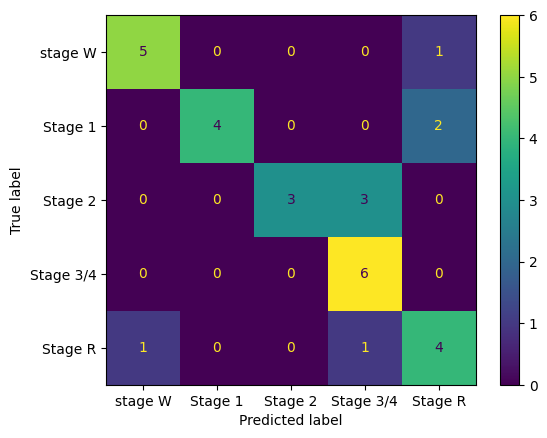

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels=[1,2,3,4,5])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ["stage W", "Stage 1", "Stage 2", "Stage 3/4", "Stage R"])
disp.plot()
plt.show()

In [25]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, y_pred)

1.8